In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import re
from sklearn import preprocessing 
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional     scklearn functions
from sklearn.model_selection import GridSearchCV
import xgboost

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

### Load Data

In [ ]:
df = pd.read_csv("../score_extra.csv",index_col=0)

In [ ]:
each_score = df["score"]

In [ ]:
each_return = df["return"]

In [ ]:
each_bad = df['bad']

### Get the sentiment score

In [ ]:
def get_score_df(each_score,each_return,each_bad,save_filename = "score_with_return.csv",threshold = 100):
    '''
    Get a dataframe with sentiment score and relative return.
    
    input:
        each_score : Series, the string of list of sentiment score 
        each_return : Series, the relative return of each_score
        save_filename : string, the file name of the data you want to save
        threshold : int,the limitation of the sum of sentiment score(cutted words)
    output:
        score : Dataframe, a dataframe which concludes sentiment scores and return
    '''
    score=pd.DataFrame(columns=[['Negative','Positive','Uncertainty','Litigious','StrongModal','WeakModal','Constraining']])

    for i in range(each_score.shape[0]):
        score.loc[each_score.index[i]] = each_score.iloc[i][1:-1].split(",")

    score=score.astype(int)
    score=pd.concat([score,each_return],axis=1)
    score=pd.concat([score,each_bad],axis=1)
    
    score=score[score.sum(axis=1)> threshold]
    score=score.reset_index()
    score.columns=['index','Negative','Positive','Uncertainty','Litigious','StrongModal','WeakModal','Constraining','return','bad']

    score.to_csv(save_filename)
    
    return score

In [ ]:
score = get_score_df(each_score,each_return,each_bad)

In [ ]:
score.head()

In [ ]:
# score.to_csv('score.csv')

### Split good and bad data

In [ ]:
print('The numbers of all companies',score.shape[0])
print('The numbers of good companies',score[score['bad'] == 0].shape[0])
print('The numbers of bad companies',score[score['bad'] == 1].shape[0])

In [ ]:
good_data = score.loc[score['bad'] == 0].values
bad_data = score.loc[score['bad'] == 1].values

In [87]:
# enlarge the bad data
multiple = int(good_data.shape[0]/bad_data.shape[0])
bad_data = np.concatenate([bad_data]*multiple,axis = 0)

In [13]:
print(bad_data.shape)

(81914, 10)


In [88]:
good_x = good_data[:,1:8]
good_y = good_data[:,8]
bad_x = bad_data[:,1:8]
bad_y= bad_data[:,8]

In [89]:
good_x.shape

(85894, 7)

In [90]:
bad_x.shape

(81914, 7)

In [102]:
data_x = score.values[:,1:8]
data_y = score.values[:,8]

length_good = int(good_data.shape[0]*0.8)
length_bad = int(bad_data.shape[0]*0.8)

train_good_x = good_data[:length_good,1:8]
train_good_y = good_data[:length_good,8]
val_good_x = good_data[length_good:,1:8]
val_good_y = good_data[length_good:,8]

train_bad_x = bad_data[:length_bad,1:8]
train_bad_y = bad_data[:length_bad,8]
val_bad_x = bad_data[length_bad:,1:8]
val_bad_y = bad_data[length_bad:,8]

### Preprocessing

In [103]:
data_x_pre = preprocessing.normalize(data_x)

train_x = preprocessing.normalize(np.concatenate([train_good_x,train_bad_x]))
train_y = np.concatenate([train_good_y,train_bad_y])

val_x = preprocessing.normalize(np.concatenate([val_good_x,val_bad_x]))
val_y = np.concatenate([val_good_y,val_bad_y])

In [91]:
all_x_pre = preprocessing.normalize(np.concatenate([good_x,bad_x]))
good_x_pre = all_x_pre[:good_x.shape[0],:] 
bad_x_pre = all_x_pre[good_x.shape[0]:,:] 

In [92]:
all_y = np.concatenate([good_y,bad_y])

### Fine tune model

In [16]:
param_test1 = {'n_estimators':[i for i in range(10,150,20)]}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, min_samples_split=300,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='neg_mean_absolute_error',cv=5,n_jobs = 12)
gsearch1.fit(data_x_pre,data_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 9.38204374, 14.54973321, 16.96195874, 19.39063029, 26.07381005,
         28.44612079, 25.66378345]),
  'mean_score_time': array([0.02566385, 0.06726532, 0.1225596 , 0.15815835, 0.1965209 ,
         0.18226318, 0.173488  ]),
  'mean_test_score': array([-0.22930358, -0.16324151, -0.16301801, -0.16350294, -0.16393184,
         -0.16429356, -0.16457572]),
  'mean_train_score': array([-0.2281554 , -0.15922156, -0.15691187, -0.15508605, -0.15333456,
         -0.15157058, -0.14992836]),
  'param_n_estimators': masked_array(data=[10, 30, 50, 70, 90, 110, 130],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 10},
   {'n_estimators': 30},
   {'n_estimators': 50},
   {'n_estimators': 70},
   {'n_estimators': 90},
   {'n_estimators': 110},
   {'n_estimators': 130}],
  'rank_test_score': array([7, 2, 1, 3, 4, 5, 6], dtype=int32),
  'split0_test_score': array([-0.2319

In [17]:
param_test2 = {'max_depth':[i for i in range(3,10,2)], 'min_samples_split':[i for i in range(30,100,20)]}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=50, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='neg_mean_absolute_error', cv=5, n_jobs = 12)
gsearch2.fit(data_x_pre,data_y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([ 4.80274377,  5.26668239,  5.39348135,  5.22103934,  8.64663262,
          8.30035453,  8.83772187,  7.99266725, 12.81527815, 12.69018807,
         11.48856015, 12.6365067 , 15.87284932, 14.64499302, 15.49262228,
         11.48214922]),
  'mean_score_time': array([0.03712258, 0.04672871, 0.04285879, 0.0419076 , 0.07094245,
         0.0813396 , 0.07969046, 0.06585422, 0.09241076, 0.09324055,
         0.09631395, 0.10820427, 0.12537994, 0.11101165, 0.11720705,
         0.06769896]),
  'mean_test_score': array([-0.1621734 , -0.1621734 , -0.1621734 , -0.1621734 , -0.16240765,
         -0.16240765, -0.16240765, -0.16240765, -0.16279418, -0.16279418,
         -0.16279418, -0.16279418, -0.16330676, -0.16330676, -0.16330676,
         -0.16330676]),
  'mean_train_score': array([-0.16154102, -0.16154102, -0.16154102, -0.16154102, -0.16054423,
         -0.16054423, -0.16054423, -0.16054423, -0.15847281, -0.15847281,
         -0.15847281, -0.15847281, -0.15484325, -0.1548

### Prediction

In [18]:
xgb = XGBRegressor(learning_rate=0.1, n_estimators=50, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10,max_depth=3,min_sample_split=30)

In [19]:
xgb.fit(train_x,train_y)
prediction = xgb.predict(val_x)

In [69]:
print('Loss', np.sum(np.square(prediction - val_y))/train_x.shape[0])

Loss 0.019261448393051092


In [21]:
# extra emotion
print('Loss', np.sum(np.square(prediction - val_y))/train_x.shape[0])

Loss 0.01925001056779609


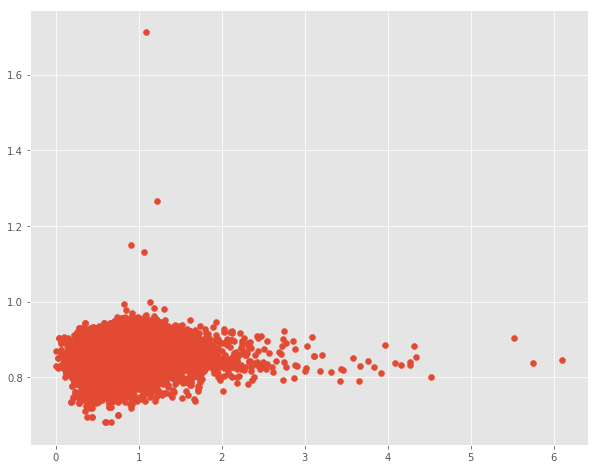

In [70]:
plt.figure(figsize=(10,8))
plt.scatter(val_y,prediction)
plt.show()

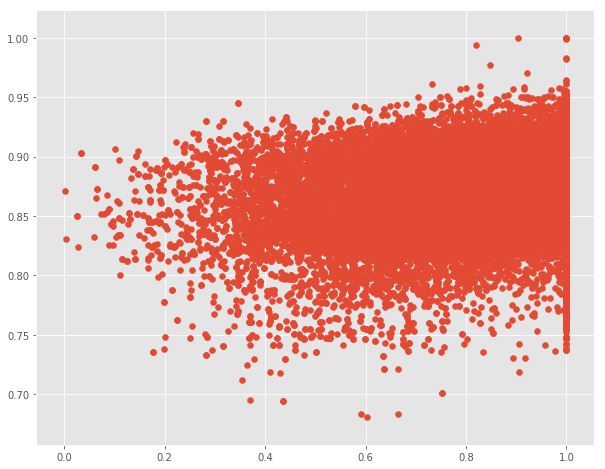

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(np.clip(val_y,0,1),np.clip(prediction,0,1))
plt.show()

### Model for good data

In [32]:
param_test1 = {'n_estimators':[i for i in range(10,150,20)]}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, min_samples_split=300,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='neg_mean_absolute_error',cv=5,n_jobs = 4)
gsearch1.fit(good_x_pre,good_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 1.25542479,  2.64825068,  4.28882895,  6.00766654,  7.72048149,
          9.43825769, 10.95695009]),
  'mean_score_time': array([0.00980163, 0.02848644, 0.05080528, 0.07126846, 0.09362378,
         0.11585302, 0.13704939]),
  'mean_test_score': array([-0.21220585, -0.13795001, -0.14043739, -0.14118684, -0.14154812,
         -0.14189866, -0.14218223]),
  'mean_train_score': array([-0.21125609, -0.1328829 , -0.13300358, -0.13170915, -0.13011062,
         -0.12853196, -0.12690051]),
  'param_n_estimators': masked_array(data=[10, 30, 50, 70, 90, 110, 130],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 10},
   {'n_estimators': 30},
   {'n_estimators': 50},
   {'n_estimators': 70},
   {'n_estimators': 90},
   {'n_estimators': 110},
   {'n_estimators': 130}],
  'rank_test_score': array([7, 1, 2, 3, 4, 5, 6], dtype=int32),
  'split0_test_score': array([-0.2151

In [33]:
param_test2 = {'max_depth':[i for i in range(3,10,2)], 'min_samples_split':[i for i in range(30,100,20)]}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=30, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='neg_mean_absolute_error', cv=5, n_jobs = 4)
gsearch2.fit(good_x_pre,good_y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.98852539, 0.96998034, 0.97280588, 0.96910167, 1.5895999 ,
         1.59088254, 1.59042945, 1.5899477 , 2.28783469, 2.28884406,
         2.28840904, 2.28010058, 2.98000207, 2.9896831 , 3.00705638,
         2.98821592]),
  'mean_score_time': array([0.01129718, 0.01115651, 0.01111212, 0.0110393 , 0.01710424,
         0.01720037, 0.01711082, 0.01716318, 0.0245954 , 0.02454939,
         0.02452655, 0.02445655, 0.033389  , 0.03347163, 0.03345571,
         0.0332231 ]),
  'mean_test_score': array([-0.13701331, -0.13701331, -0.13701331, -0.13701331, -0.13726255,
         -0.13726255, -0.13726255, -0.13726255, -0.1376409 , -0.1376409 ,
         -0.1376409 , -0.1376409 , -0.13826639, -0.13826639, -0.13826639,
         -0.13826639]),
  'mean_train_score': array([-0.13657501, -0.13657501, -0.13657501, -0.13657501, -0.13582825,
         -0.13582825, -0.13582825, -0.13582825, -0.13414127, -0.13414127,
         -0.13414127, -0.13414127, -0.13111764, -0.13111764, -0.1311176

In [34]:
xgb = XGBRegressor(learning_rate=0.1, n_estimators=30, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10,max_depth=3,min_sample_split=30)

In [35]:
xgb.fit(good_x_pre,good_y)
prediction = xgb.predict(good_x_pre)

In [93]:
prediction_bad = xgb.predict(bad_x_pre)

In [94]:
loss_good = np.square(prediction - good_y)
loss_bad = np.square(prediction_bad - bad_y)

print('Loss_good', np.sum(loss_good)/good_y.shape[0])
print('Loss_bad', np.sum(loss_bad)/bad_y.shape[0])


Loss_good 0.055361274212463514
Loss_bad 0.16729869613310847


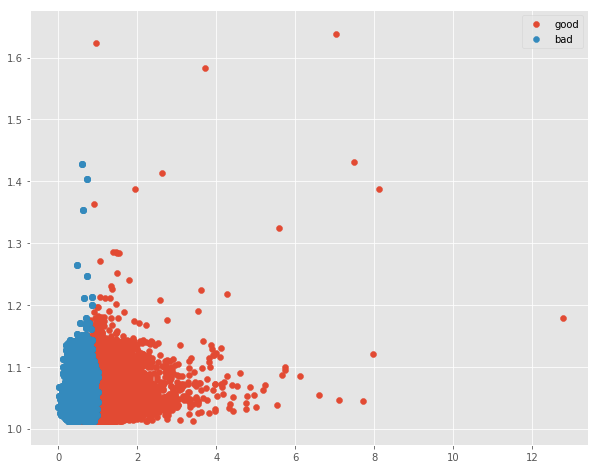

In [96]:
plt.figure(figsize=(10,8))
plt.scatter(good_y,prediction,label='good')
plt.scatter(bad_y,prediction_bad,label='bad')
plt.legend(loc='upper right')
plt.show()

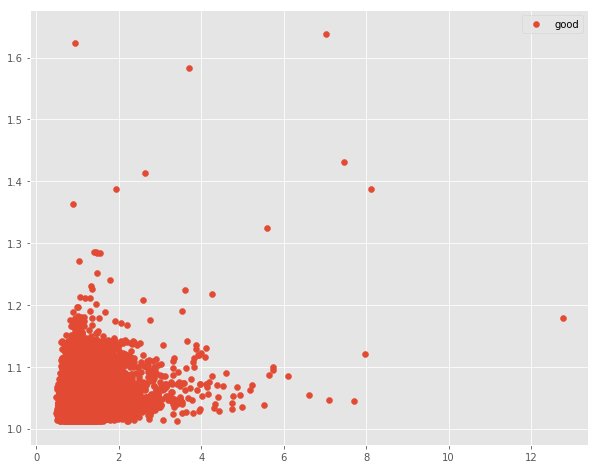

In [42]:
plt.figure(figsize=(10,8))
plt.scatter(good_y,prediction,label='good')
# plt.scatter(bad_y,prediction_bad,label='bad')
plt.legend(loc='upper right')
plt.show()

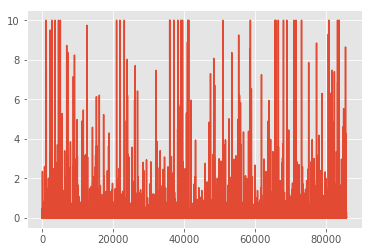

In [47]:
plt.plot(np.clip(loss_good,0,10))
plt.show()

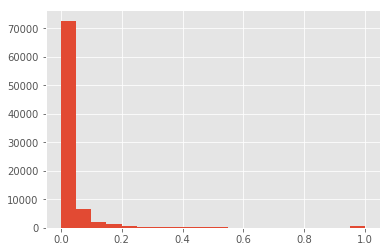

In [68]:
plt.hist(np.clip(loss_good,0,1),bins=20)
plt.show()

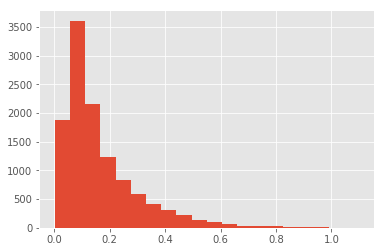

In [66]:
plt.hist(np.sort(loss_bad),bins=20)
plt.show()

In [98]:
prediction_all = xgb.predict(all_x_pre)

loss_all = np.square(prediction_all - all_y)

train_length = int(good_x.shape[0]+bad_x.shape[0]*0.8)
loss_t = loss_all[:train_length]
loss_v = np.concatenate([loss_all[:good_x.shape[0]],loss_all[train_length:]])

labels = np.array([1]*good_x.shape[0] + [0]*bad_x.shape[0])
labels_t = labels[:train_length]
labels_v = np.concatenate([labels[:good_x.shape[0]],labels[train_length:]])

In [99]:
def get_threshold(loss):
    loss_sort = np.sort(loss)
    thres = []
    for i,l in enumerate(loss_sort):
        if(i == 0):
            thres.append((0+l)/2)
        else:
            thres.append((l+loss_sort[i-1])/2)
    thres.append((1+loss_sort[-1])/2)
    return thres

def get_best_threshold(labels,loss_all,thre_list):
    b_err = 10
    length = labels.shape[0]
    
    for thre in thre_list:
        pre = np.zeros((length))
        pre[loss_all<thre] = 1
        err = np.sum(labels != pre)/length
        if(err < b_err):
            b_err = err
            b_thr = thre
    return b_err,b_thr

In [100]:
thre_list = get_threshold(loss_all)

b_err,b_thr = get_best_threshold(labels,loss_all,thre_list)

print(b_err)
print(b_thr)

0.1316742944317315
0.04000993494015087


In [101]:
thre_list = get_threshold(loss_t)
b_err,b_thr = get_best_threshold(labels_t,loss_t,thre_list)

print('Ein',b_err)
print('Ein_thr',b_thr)

length_v = labels_v.shape[0]
pre_v = np.zeros((length_v))
pre_v[loss_v<b_thr] =1
err = np.sum(labels_v != pre_v)/length_v
print('E_out',err)

length = labels.shape[0]
pre = np.zeros((length))
pre[loss_all<b_thr] =1
err = np.sum(labels != pre)/length
print('E_all',err)

Ein 0.1376060756149909
Ein_thr 0.04126670612650797
E_out 0.16732012084828457
E_all 0.13176368230358504
